In [5]:
from graphdatascience import GraphDataScience
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from getpass import getpass
from sentence_transformers import SentenceTransformer
from langdetect import detect, LangDetectException

# Demonstrate embeddings on some test sentences

In [6]:
test_sentences = pd.DataFrame( 
    [["I like to play Minecraft.", "en"],
      ["J'aime jouer à Minecraft.", "fr"],
      ["Jag gillar att spela Minecraft.", "se"],
      ["Neo4j is a graph database.", "en"],
      ["Neo4j est une base de données graphique.", "fr"],
      ["Neo4j är en grafdatabase.", "se"]], columns=["sentence", "language"])


In [7]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
test_embeddings = model.encode((test_sentences['sentence'].to_list()))

In [9]:
reducer = umap.UMAP(n_components=2)
embedding_reduced = reducer.fit_transform(test_embeddings)

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [10]:
test_umap_df = pd.DataFrame(embedding_reduced, columns=['umap1', 'umap2'])
test_sentences = pd.concat([test_sentences, test_umap_df], axis=1)

In [11]:
fig = px.scatter(test_sentences, x='umap1', y='umap2', color='language', text=test_sentences['sentence'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.update_traces(
        marker=dict(size=20),  # Increase point size
        textposition='top center'  # Position of the text labels
    )   
fig.show()

# Connect to Neo4j

In [12]:
bolt_url = "bolt://54.196.239.38:7687"

In [13]:
gds = GraphDataScience(bolt_url, auth=("neo4j", getpass("Neo4j password")))

# Create embeddings for streamer descriptions

In [14]:
descriptions_df = gds.run_cypher("MATCH (s:Stream) WHERE s.description IS NOT NULL and size(s.description) > 1 RETURN id(s) AS nodeId, s.description AS description")

In [15]:
descriptions_df.head(25)

,nodeId,description
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin..."
1,3,I'm a variety streamer(kind of). Been streamin...
2,5,感謝します。
3,8,Топовая студия в мире профессионального киберс...
4,11,Maximilian's Livestream Of Hype! Modern fighti...
5,14,楽しんでゲームしていきます
6,15,spawns at midnight (pst)
7,16,On se tape des immenses barres.
8,19,Welcome to my stream! My name is Amouranth and...
9,21,Yes | Epic Gamer | Content Creator for Luminos...


In [16]:
description_embeddings = model.encode(descriptions_df['description'].to_list())

In [17]:
descriptions_df['description_embedding'] = description_embeddings.tolist()

# Detect the language of the descriptions

In [18]:
def detect_language(text):
    try:
        language = detect(text)
        return language
    except LangDetectException:
        return "Uknown"

In [19]:
descriptions_df['language'] = descriptions_df['description'].map(detect_language)

In [20]:
descriptions_df.head()

,nodeId,description,description_embedding,language
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.0411677248775959, 0.015329533256590366, -0....",en
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.031273022294044495, 0.021538781002163887, -...",en
2,5,感謝します。,"[0.047866880893707275, -0.02418091706931591, -...",ja
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097575977444649, 0.00705910287797451, -...",ru
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260038167238235, 0.008335496298968792, -...",en


In [21]:
descriptions_df['language'].value_counts()

language
en        1722
es         299
ko         237
de         230
fr         215
pt         187
ru         169
it         147
tr         107
pl          63
ja          45
Uknown      38
nl          35
fi          27
id          26
hu          25
so          25
no          25
tl          25
th          22
da          22
ca          21
et          17
cs          16
cy          15
ar          14
sw          14
af          13
zh-tw       13
bg          11
ro          11
vi           9
hr           9
sk           9
uk           8
sv           7
zh-cn        5
mk           4
lv           3
lt           3
sl           3
sq           2
el           1
fa           1
Name: count, dtype: int64

# Upload results to Neo4j

In [22]:
gds.run_cypher("""
UNWIND $data AS row
MATCH (n) WHERE id(n) = row['nodeId']
SET n.language = row['language']
WITH n, row
CALL db.create.setNodeVectorProperty(n, "descriptionEmbedding", row['description_embedding'])
               """, {"data": descriptions_df.to_dict('records')})

""


# Create graph projection

In [23]:
gds.graph.drop("descriptions")

g_descriptions, result = gds.graph.cypher.project("""
    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERACTORS]->(s2:Stream)
    WHERE s1.descriptionEmbedding IS NOT NULL AND s2.descriptionEmbedding IS NOT NULL
    RETURN gds.graph.project(
        "descriptions",
        s1,
        s2,
        {
            sourceNodeProperties: s1{.descriptionEmbedding},
            targetNodeProperties: s2{.descriptionEmbedding},
            relationshipProperties: r{.similarity},
            relationshipType: "HAS_SIMILAR_CONTACTS"
        },
        {
            undirectedRelationshipTypes: ["HAS_SIMILAR_CONTACTS"]
        })"""
)
result

relationshipCount                                                25104
graphName                                                 descriptions
query                \n    MATCH (s1:Stream)-[r:HAS_SIMILAR_INTERAC...
projectMillis                                                      529
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                         3777
dtype: object

# Run fastRP with and without properties

In [25]:
gds.fastRP.write(g_descriptions, 
                 propertyRatio = 1.0,
                 featureProperties = ["descriptionEmbedding"],
                 embeddingDimension = 256,
                 iterationWeights = [0.0, 1.0, 1.0],
                 randomSeed = 24,                               
                 relationshipWeightProperty = "similarity",
                 writeProperty = "fastRPDescriptionEmbedding")

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          435
writeMillis                                                           1256
configuration            {'writeProperty': 'fastRPPropertyEmbedding', '...
Name: 0, dtype: object

In [ ]:
fastRP_description_df = gds.run_cypher("MATCH s:Stream WHERE fastRPDescriptionEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPDescriptionEmbedding AS fastRP_description_embedding")

In [27]:
descriptions_df = descriptions_df.merge(fastRP_description_df, on="nodeId")

In [29]:
gds.fastRP.write(g_descriptions, 
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity",
                               writeProperty="fastRPNoPropertyEmbedding")

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          250
writeMillis                                                           1439
configuration            {'writeProperty': 'fastRPNoPropertyEmbedding',...
Name: 0, dtype: object

In [30]:
fastRP_no_props_df = gds.run_cypher("MATCH s:Stream WHERE fastRPNoPropertyEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPNoPropertyEmbedding AS fastRP_no_property_embedding")

In [31]:
descriptions_df = descriptions_df.merge(fastRP_df_no_props, on="nodeId")

# Run WCC
Visualizations will make more sense with isolated nodes excluded.

In [32]:
wcc_df = gds.wcc.stream(g_descriptions)
descriptions_df = descriptions_df.merge(wcc_df, on="nodeId")

# Use UMAP to reduce embeddings to two dimensions for plotting

In [33]:
description_embedding_reduced = reducer.fit_transform(np.array(list(descriptions_df['description_embedding'])))
description_umap_df = pd.DataFrame(description_embedding_reduced, columns=['description_umap1', 'description_umap2'])
descriptions_df = pd.concat([descriptions_df, description_umap_df], axis=1)

In [34]:
fastrp_property_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_description_embedding'])))
fastRP_prop_umap_df = pd.DataFrame(fastrp_property_reduced, columns=['fastRP_description_umap1', 'fastRP_description_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_prop_umap_df], axis=1)

In [35]:
fastrp_no_prop_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_no_property_embedding'])))
fastRP_no_prop_umap_df = pd.DataFrame(fastrp_no_prop_reduced, columns=['fastRP_no_property_umap1', 'fastRP_no_property_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_no_prop_umap_df], axis=1)

In [36]:
descriptions_df.head()

,nodeId,description,description_embedding,language,fastRP_property_embedding,fastRP_no_property_embedding,componentId,description_umap1,description_umap2,fastRP_property_umap1,fastRP_property_umap2,fastRP_no_property_umap1,fastRP_no_property_umap2
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.0411677248775959, 0.015329533256590366, -0....",en,"[0.051113102585077286, 0.05236228555440903, -0...","[-0.1664474606513977, -0.24395164847373962, 0....",0,5.794335,4.755510,17.414368,17.335655,9.377432,14.107494
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.031273022294044495, 0.021538781002163887, -...",en,"[0.140514075756073, 0.07159759849309921, 0.082...","[-0.0023961104452610016, -0.0728759765625, 0.0...",0,4.729811,4.657945,8.102278,12.108577,9.136986,5.346869
2,5,感謝します。,"[0.047866880893707275, -0.02418091706931591, -...",ja,"[0.06569905579090118, 0.1434735208749771, 0.09...","[0.01177993230521679, -0.025558914989233017, -...",0,7.084440,-0.366325,21.167299,10.478276,8.463766,5.536960
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097575977444649, 0.00705910287797451, -...",ru,"[0.23918992280960083, 0.15352551639080048, 0.1...","[0.11161068081855774, -0.008263396099209785, 0...",0,4.284468,2.440029,12.154228,8.528831,10.003715,2.615814
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260038167238235, 0.008335496298968792, -...",en,"[0.26717692613601685, 0.07116031646728516, 0.0...","[-0.03769935294985771, -0.07377389073371887, 0...",0,5.353062,2.406709,16.193560,12.108536,9.128243,5.304596


# Visualize embeddings

In [37]:
fig = px.scatter(descriptions_df, x='description_umap1', y='description_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [38]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_property_umap1', y='fastRP_property_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [39]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_no_property_umap1', y='fastRP_no_property_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

# Create vector indexes for embeddings 

In [40]:
gds.run_cypher("""
               CREATE VECTOR INDEX descriptionEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.descriptionEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 512,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [41]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPNoPropertyEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPNoPropertyEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [42]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPPropertyEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPNoPropertyEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


# Find the five most similar nodes for each streamer based on embeddings 
Find out if the neighbors are within 2 hops of the streamer, the cosine similarity score for the description embeddings, and whether the languages match

In [45]:
prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPDescriptionEmbedding", 6, s.fastRPDescriptionEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

In [46]:
no_prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPNoPropertyEmbedding", 6, s.fastRPNoPropertyEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

In [67]:
description_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoPropertyEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("descriptionEmbedding", 6, s.descriptionEmbedding) 
YIELD node, score
WHERE node <> s
AND node.fastRPNoPropertyEmbedding IS NOT NULL                                        
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch,
gds.similarity.cosine(s.fastRPPropertyEmbedding, node.fastRPPropertyEmbedding) AS fastRPPropertySim,
gds.similarity.cosine(s.fastRPNoPropertyEmbedding, node.fastRPNoPropertyEmbedding) AS fastRPNoPropertySim
                                          """)

# Check stats for the different sets of neighbors

In [64]:
prop_neighbors_df.apply('mean')

pathCount         0.751123
descriptionSim    0.157892
languageMatch     0.409792
dtype: float64

In [65]:
no_prop_neighbors_df.apply('mean')

pathCount         0.895544
descriptionSim    0.146973
languageMatch     0.454832
dtype: float64

In [68]:
description_neighbors_df.apply('mean')

pathCount              0.092483
descriptionSim         0.545554
languageMatch          0.329783
fastRPPropertySim      0.656524
fastRPNoPropertySim    0.079629
dtype: float64

Similar property-based embeddings does not imply that two nodes are a lot closer together in the input feature space than similar non-property based embeddings.

* The node embedding is based on an aggregation of features of all the nodes in the neighborhood, not just the node that gets the embedding.
* If the neighborhood nodes' features are not very similar to the target node, it is less likely that neighbors close in the embedding space will have similar feature vectors


/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



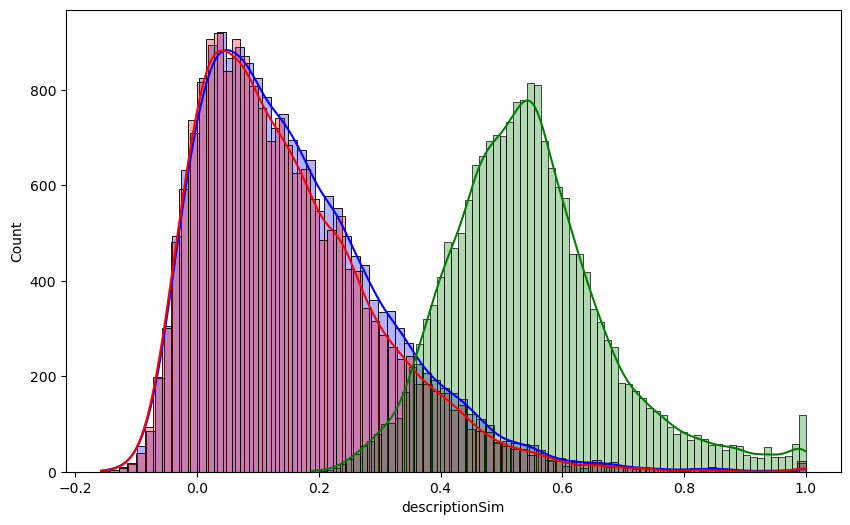

In [53]:
plt.figure(figsize=(10, 6))

sns.histplot(data=prop_neighbors_df, x='descriptionSim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=no_prop_neighbors_df, x='descriptionSim', kde=True, color='red', alpha=0.3, label='FastRP without properties')
sns.histplot(data=description_neighbors_df, x='descriptionSim', kde=True, color='green', alpha=0.3, label='Description embeddings')

plt.show()

Find the median embedding similarity for `Stream` nodes that share a `HAS_SIMILAR_INTERACTORS` relationship.

In [61]:
gds.run_cypher("""
MATCH (s1:Stream)-[:HAS_SIMILAR_INTERACTORS]->(s2)
WHERE s1.descriptionEmbedding IS NOT NULL
AND s2.descriptionEmbedding IS NOT NULL
RETURN percentileCont(gds.similarity.cosine(s1.descriptionEmbedding, s2.descriptionEmbedding), 0.5) AS medianEmbeddingSimilarity
""")

,medianEmbeddingSimilarity
0,0.126082


Two nodes that are close in the feature space will be closer in the property based embedding space than the non-property-based embedding space.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



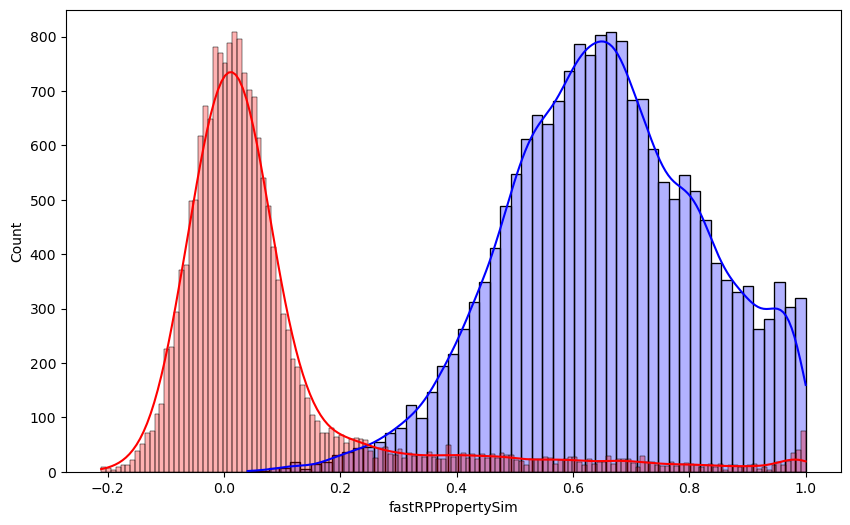

In [70]:
plt.figure(figsize=(10, 6))

sns.histplot(data=description_neighbors_df, x='fastRPPropertySim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=description_neighbors_df, x='fastRPNoPropertySim', kde=True, color='red', alpha=0.3, label='FastRP without properties')

plt.show()

In [ ]:
gds.graph.drop(g_descriptions)